In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical

In [130]:
#importing dataset and distribute it!
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
y_test_data = pd.read_csv('y_test.csv')
#X contains independent variable
X_train = train_data.iloc[:,1:-1].values

#Y contains dependent variable i.e., house price 
Y_train = train_data.iloc[:,80].values

#X_test contain independent variables of test data
X_test = test_data.iloc[:,1:].values

#Y_test contain dependent variables of test data
Y_test = y_test_data.iloc[:,1:].values

#conversion from vecctor to matrix
Y_train = Y_train.reshape((X_train.shape[0], 1))
Y_test = Y_test.reshape((X_test.shape[0], 1))

#normalize the Y-axis
from sklearn.preprocessing import StandardScaler
sy = StandardScaler()
Y_train = sy.fit_transform(Y_train)
st = StandardScaler()
Y_test = st.fit_transform(Y_test)
Y_test = Y_test.T
Y_train = Y_train.T

In [131]:
def preprocessing(X):
    #converting NAN in string variable into string variable 'a'
    #hot - data contain string variables
    hot = [1,4,5,6,7,8,9,10,11,12,13,14,15,20,21,22,23,24,26,27,28,29,30,31,32,34,38,39,40,41,52,54,56,57,59,62,63,64,71,72,73,77,78]
    m = X.shape[0]
    df  = pd.DataFrame(X)
    for j in range(79):
        for i in range(m):
            if X[i,j] == 'None' or X[i,j] == None:
                X[i,j] = 'a'

    for i in hot:
        df[i].fillna('a', inplace = True)
        
    #X_mod - X modification with encoding of string variable and categorical data
    X_mod = np.zeros((m,267 + (X.shape[1] - len(hot))))
    
    #Encoding the string variable then convert into categorical variables
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    z = 0
    a=0
    q=0
    for i in hot:
        x = 0
        labelencoder_X = LabelEncoder()
        x = labelencoder_X.fit_transform(X[:,i])
        x = to_categorical(x)
        q += x.shape[1]
        X_mod[:,z:z + x.shape[1]] = x.astype(int)
        z +=  x.shape[1]
        
    
        #norm - indexes of numerical values
    norm = [0,2,3,16,17,18,19,25,33,35,36,37,42,43,44,45,46,47,48,49,50,51,53,55,58,60,61,65,66,67,68,69,70,74,75,76]
    #x_norm - matrix of zeros of shape (m, no. of numerical values)
    x_norm = np.zeros((m,len(norm)))
    a=0
    for i in norm:
        x_norm[:,a] = X[:,i]
        a+=1
        
    #removing the 'NaN' values from whole numerical dataset 
    from sklearn.preprocessing import Imputer
    imputer = Imputer(missing_values='NaN', strategy='mean',axis=0)
    imputer = imputer.fit(x_norm)
    x_norm = imputer.transform(x_norm)
    
    #scaling the x_norm matrix
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    x_norm = sc.fit_transform(x_norm)
    
    #updating X_mod matrix with full dataset
    X_mod[:,267:] = x_norm
    return X_mod

In [132]:
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)
X_train = X_train[:,1:]
X_test = X_test[:,1:]
X_train = X_train.T
X_test = np.float32(X_test.T)
print(X_test.dtype)

float32


c:\users\pushkar khetrapal\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\pushkar khetrapal\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [133]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(302, 1460)
(302, 1459)
(1, 1460)
(1, 1459)


In [134]:
import tensorflow as tf

In [135]:
#create placeholder
def create_placeholder(n_x,n_y):
    X = tf.placeholder(tf.float32,[n_x,None], name='X')
    Y = tf.placeholder(tf.float32, [n_y,None], name='Y')
    
    return X,Y

In [136]:
#Initializing the placeholder

def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable('W1',[40,302], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [40,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable('W2', [8, 40], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [8,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable('W3', [1,8], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [1,1], initializer = tf.zeros_initializer())
    
    parameters = {'W1':W1,
                  'b1':b1,
                  'W2':W2,
                  'b2':b2,
                  'W3':W3,
                  'b3':b3
                 }
    return parameters

In [137]:
#forward propogation in tensorflow
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    
    return Z3

In [138]:
#compute cost
def compute_cost(Z3,Y):
    
    cost = cost = tf.reduce_sum(tf.pow(Z3 - Y, 2)) / (2 * 1460)
    
    return cost

In [139]:
def random_mini_batches(X, Y, mini_batch_size = 73, seed = 0):
    
    np.random.seed(seed)            
    m = X.shape[1]                  
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    num_complete_minibatches = np.math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:

        end = m - mini_batch_size * np.math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [140]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.0001,num_epochs=1500,minibatch_size=73,print_cost=True):
    ops.reset_default_graph()
    
    tf.set_random_seed(1)
    seed=3
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs=[]
    
    X,Y = create_placeholder(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)

    cost = tf.reduce_sum(tf.square(Z3-Y))
    
    #Backpropagation using ADAM optimizer
    Y_pred = forward_propagation(X_test, parameters)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0
            
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                minibatch_x, minibatch_y = minibatch
                
                _, minibatch_cost, y_p = sess.run([optimizer, cost, Y_pred], feed_dict = {X:minibatch_x,Y:minibatch_y})
            
            epoch_cost += minibatch_cost/num_minibatches
            
            if print_cost == True and epoch%100 == 0:
                print('cost after epoch %i : %f'%(epoch,epoch_cost))
            if print_cost == True and epoch%5 == 0:
                costs.append(epoch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title('Learning rate = ' + str(learning_rate))
        plt.show()
    
        parameters = sess.run(parameters)
    
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
    
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))
    
        #print("train Accuracy ", accuracy.eval({X:X_train,Y:Y_train}))
        #print("train Accuracy ", accuracy.eval({X:X_test,Y:Y_test}))
    
    return parameters, y_p

cost after epoch 0 : 5.570636
cost after epoch 100 : 0.199051
cost after epoch 200 : 0.073645
cost after epoch 300 : 0.068738
cost after epoch 400 : 0.021539
cost after epoch 500 : 0.009786
cost after epoch 600 : 0.004445
cost after epoch 700 : 0.004722
cost after epoch 800 : 0.000598
cost after epoch 900 : 0.000997
cost after epoch 1000 : 0.004632
cost after epoch 1100 : 0.004843
cost after epoch 1200 : 0.000354
cost after epoch 1300 : 0.000343
cost after epoch 1400 : 0.000033


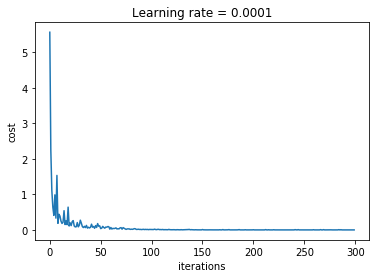

In [141]:
from tensorflow.python.framework import ops
parameters, y_p = model(X_train, Y_train, X_test, Y_test)

In [142]:
##############################    5 - Layers Neural Network     ####################################

In [143]:
#create placeholder
def create_placeholder_5(n_x,n_y):
    X = tf.placeholder(tf.float32,[n_x,None], name='X')
    Y = tf.placeholder(tf.float32, [n_y,None], name='Y')
    
    return X,Y

In [144]:
#Initializing the placeholder

def initialize_parameters_5():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable('W1',[40,302], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [40,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable('W2', [20, 40], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [20,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable('W3',[10,20], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [10,1], initializer = tf.zeros_initializer())
    W4 = tf.get_variable('W4', [10, 10], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b4 = tf.get_variable('b4', [10,1], initializer = tf.zeros_initializer())
    W5 = tf.get_variable('W5', [1,10], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b5 = tf.get_variable('b5', [1,1], initializer = tf.zeros_initializer())
    
    parameters = {'W1':W1,
                  'b1':b1,
                  'W2':W2,
                  'b2':b2,
                  'W3':W3,
                  'b3':b3,
                  'W4':W4,
                  'b4':b4,
                  'W5':W5,
                  'b5':b5
                 }
    return parameters

In [145]:
#forward propogation in tensorflow
def forward_propagation_5(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    A4 = tf.nn.relu(Z4)
    Z5 = tf.add(tf.matmul(W5, A4), b5)

    
    return Z3 

In [146]:
def model_5(X_train,Y_train,X_test,Y_test,learning_rate=0.0001,num_epochs=1500,minibatch_size=73,print_cost=True):
    ops.reset_default_graph()
    
    tf.set_random_seed(1)
    seed=3
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs=[]
    
    X,Y = create_placeholder_5(n_x, n_y)
    parameters = initialize_parameters_5()
    Z3 = forward_propagation_5(X, parameters)

    cost = tf.reduce_sum(tf.square(Z3-Y))
    
    #Backpropagation using ADAM optimizer
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        Y_pred = forward_propagation_5(X_test, parameters)
        for epoch in range(num_epochs):
            epoch_cost = 0
            
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                minibatch_x, minibatch_y = minibatch
                
                _, minibatch_cost, y_p = sess.run([optimizer, cost, Y_pred], feed_dict = {X:minibatch_x,Y:minibatch_y})
            
            epoch_cost += minibatch_cost/num_minibatches
            
            if print_cost == True and epoch%100 == 0:
                print('Cost after epoch %i : %f'%(epoch,epoch_cost))
            if print_cost == True and epoch%5 == 0:
                costs.append(epoch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title('Learning rate = ' + str(learning_rate))
        plt.show()
    
        parameters = sess.run(parameters)
    
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
    
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))
    
        print("train Accuracy ", accuracy.eval({X:X_train,Y:Y_train}))
        #print("train Accuracy ", accuracy.eval({X:X_test,Y:Y_test}))
    
    return parameters, y_p

Cost after epoch 0 : 31.080124
Cost after epoch 100 : 2.494944
Cost after epoch 200 : 1.248515
Cost after epoch 300 : 0.901934
Cost after epoch 400 : 0.449180
Cost after epoch 500 : 0.293688
Cost after epoch 600 : 0.114826
Cost after epoch 700 : 0.131000
Cost after epoch 800 : 0.086127
Cost after epoch 900 : 0.042547
Cost after epoch 1000 : 0.017705
Cost after epoch 1100 : 0.115850
Cost after epoch 1200 : 0.012702
Cost after epoch 1300 : 0.012541
Cost after epoch 1400 : 0.009090


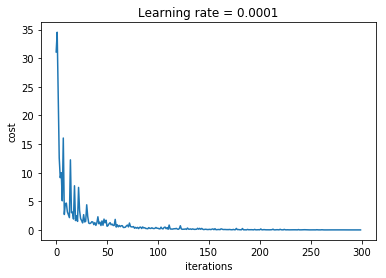

train Accuracy  0.090410955


In [147]:
from tensorflow.python.framework import ops
parameters_5, y_p = model_5(X_train, Y_train, X_test, Y_test)